In [41]:
import numpy as np
import pandas as pd
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modules
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin

# TensorFlow/Keras modules
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Machine Learning models
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import optuna


In [42]:
print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())
print("Is GPU available?", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.16.2
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Import data

In [43]:
df = pd.read_csv('data/malmem2024-osef.csv')
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)

Data Preprocessing

In [44]:
def categorize_malware(category):
    if category.startswith("Ransomware"):
        return "Ransomware"
    elif category.startswith("Trojan"):
        return "Trojan"
    elif category.startswith("Spyware"):
        return "Spyware"
    elif category == "Benign":
        return "Benign"
    else:
        return "Unknown"

In [45]:
df["GeneralCategory"] = df["Category"].apply(categorize_malware)

In [46]:
label_encoder = LabelEncoder()
df["EncodedCategory"] = label_encoder.fit_transform(df["GeneralCategory"])  

In [47]:
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:", class_mapping)  # Example: {'Benign': 0, 'Ransomware': 1, 'Spyware': 2, 'Trojan': 3}

Label Encoding Mapping: {'Benign': 0, 'Ransomware': 1, 'Spyware': 2, 'Trojan': 3}


In [48]:
X = df.drop(columns=["Category", "GeneralCategory", "EncodedCategory", "Class"])  # Drop target columns
y = df["EncodedCategory"]  # Use the encoded labels

In [49]:
X.sample(50)

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nport,...,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
35535,44,18,9.545455,0,206.204545,1723,39.159091,9073,206.204545,0,...,389,221,26,24,116,0,122,87,0,8
43593,40,16,9.875000,0,208.750000,1556,38.900000,8350,208.750000,0,...,389,221,26,24,116,0,122,87,0,8
17726,43,12,13.441642,0,310.601457,2219,51.605470,13356,310.601457,0,...,395,222,26,27,118,0,124,88,0,8
57013,40,16,9.450000,0,203.175000,1502,37.550000,8127,203.175000,0,...,389,221,26,24,116,0,119,87,0,8
31592,44,17,10.113636,0,210.795455,1718,39.045455,9276,215.720930,0,...,389,221,26,24,116,0,122,87,0,8
18115,40,12,13.409411,0,305.160279,2091,52.275000,12206,305.160279,0,...,395,222,26,27,118,0,123,88,0,8
21073,41,12,13.494125,0,307.838912,2149,52.414634,12621,307.838912,0,...,395,222,26,27,118,0,123,88,0,8
8579,41,12,12.902439,0,291.090611,2031,49.536585,11934,291.090611,0,...,395,222,26,27,118,0,122,88,0,8
29335,43,17,9.325581,0,198.046512,1612,37.488372,8516,198.046512,0,...,389,221,26,24,116,0,122,86,0,8
9734,43,14,12.953488,0,287.004166,2104,48.930233,12341,287.004166,0,...,395,222,26,27,118,0,123,88,0,8


In [50]:
# Drop features where all values are the same
X_filtered = X.loc[:, X.nunique() > 1]

print(f"Removed {X.shape[1] - X_filtered.shape[1]} constant-value features")


Removed 3 constant-value features


In [51]:
X_filtered.head()

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nfile,handles.nevent,...,modules.nmodules,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
0,45,17,10.555556,202.844444,1694,38.500000,9129,212.302326,670,3161,...,138,389,221,26,24,116,121,87,0,8
1,47,19,11.531915,242.234043,2074,44.127660,11385,242.234043,840,3761,...,138,392,222,26,24,118,122,87,0,8
2,40,14,14.725000,288.225000,1932,48.300000,11529,288.225000,1050,3996,...,137,395,222,26,27,118,120,88,0,8
3,32,13,13.500000,264.281250,1445,45.156250,8457,264.281250,630,2961,...,138,395,222,26,27,118,120,88,0,8
4,42,16,11.452381,281.333333,2067,49.214286,11816,281.333333,908,3834,...,138,392,222,26,24,118,124,87,0,8


In [52]:
class_distribution = df["EncodedCategory"].value_counts()
print(class_distribution)

EncodedCategory
0    29231
2     9815
1     9529
3     9487
Name: count, dtype: int64


In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.2, stratify=y, random_state=42
)

In [54]:
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

/var/folders/g3/b62gb6fx307526l7s35ss6zh0000gn/T/ipykernel_20601/1569515085.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts().values, palette="coolwarm")


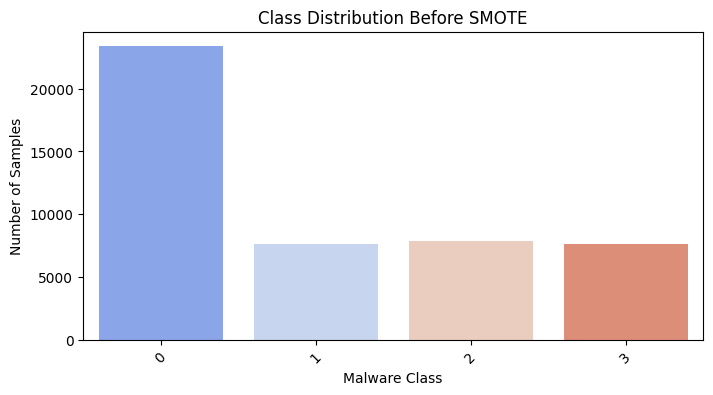

In [55]:
plt.figure(figsize=(8, 4))
sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts().values, palette="coolwarm")
plt.xlabel("Malware Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution Before SMOTE")
plt.xticks(rotation=45)
plt.show()

In [56]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

/var/folders/g3/b62gb6fx307526l7s35ss6zh0000gn/T/ipykernel_20601/2592860423.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_train_resampled.value_counts().index, y=y_train_resampled.value_counts().values, palette="coolwarm")


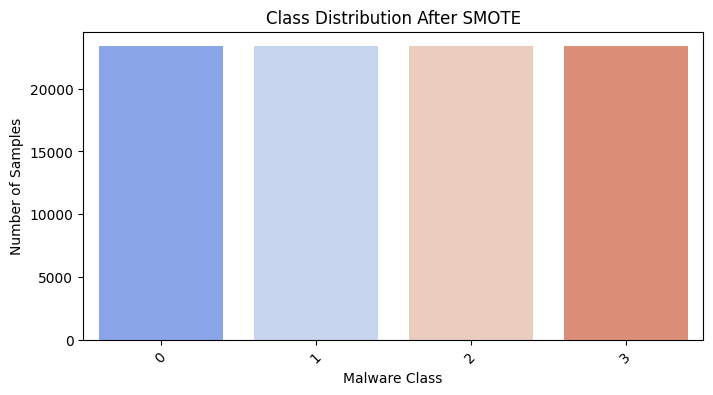

In [57]:
plt.figure(figsize=(8, 4))
sns.barplot(x=y_train_resampled.value_counts().index, y=y_train_resampled.value_counts().values, palette="coolwarm")
plt.xlabel("Malware Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After SMOTE")
plt.xticks(rotation=45)
plt.show()

In [58]:
class_distribution = y_train_resampled.value_counts()
print(class_distribution)

EncodedCategory
0    23384
1    23384
3    23384
2    23384
Name: count, dtype: int64


In [59]:
num_features = X_train_resampled.shape[1]
print(f"Number of features: {num_features}")

Number of features: 52


XGBoost Model

In [60]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.3),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 1e-1),  # L1 regularization
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 1e-1),  # L2 regularization
    }

    # Create XGBoost model
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric="mlogloss", random_state=42)

    # Cross-validation score
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=3, scoring='accuracy')

    return scores.mean()  # Optimize for highest accuracy


In [61]:
# Run Optuna optimization with TPE sampler
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=150)  

# Best parameters found by Optuna
best_xgb_params = study.best_params
print("\nBest XGBoost Parameters (Optuna):", best_xgb_params)

[I 2025-03-07 19:28:06,569] A new study created in memory with name: no-name-1ecc1fe0-4195-4c5d-b452-ddbe58a8b47b
/var/folders/g3/b62gb6fx307526l7s35ss6zh0000gn/T/ipykernel_20601/2663000904.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 1.0),
/var/folders/g3/b62gb6fx307526l7s35ss6zh0000gn/T/ipykernel_20601/2663000904.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 1e-1),  # L1 regularization
/var/folders/g3/b62gb6fx307526l7s35ss6zh0000gn/T/ipykernel_20601/2663000904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

KeyboardInterrupt: 

In [ ]:
# Train the best XGBoost model
best_xgb_model = xgb.XGBClassifier(**best_xgb_params, use_label_encoder=False, eval_metric="mlogloss")
best_xgb_model.fit(X_train_resampled, y_train_resampled)

print("\nXGBoost Model Trained Successfully!")


In [ ]:
xgb_results = evaluate_model(best_xgb_model, X_test_scaled, y_test, model_name="XGBoost")

In [ ]:
# Save the trained Random Forest model
joblib.dump(best_xgb_model, "best_xgb_model.pkl")

print("XGBoost model saved successfully!")


Random Forest Model

In [ ]:
def objective(trial):
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 700),
        'max_depth': trial.suggest_int('max_depth', 10, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    # Create RF model
    model = RandomForestClassifier(n_jobs=-1, **params, random_state=42, class_weight="balanced")

    # Perform cross-validation
    score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=3, scoring='accuracy').mean()

    # Print results for each trial
    print(f"Trial {trial.number}: {params} → Accuracy: {score:.4f}")

    return score

In [ ]:
# Run Optuna with TPE sampler
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=150)

In [ ]:
# Print best parameters
best_rf_params = study.best_params
print("\nBest RF Parameters (Optuna):", best_rf_params)

In [ ]:
# Train Random Forest with best Optuna parameters
best_rf_model = RandomForestClassifier(**best_rf_params, n_jobs=-1, random_state=42)
best_rf_model.fit(X_train_resampled, y_train_resampled)

print("Random Forest Model Trained Successfully!")

In [ ]:
rf_results = evaluate_model(best_rf_model, X_test_scaled, y_test, model_name="Random Forest")

In [ ]:
# Save the trained Random Forest model
joblib.dump(best_rf_model, "best_rf_model.pkl")

print("Random Forest model saved successfully!")


LightGBM Model

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 1e-1),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 1e-1),
    }

    # Train LightGBM model
    model = LGBMClassifier(**params, random_state=42)
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=3, scoring='accuracy')
    return scores.mean()

In [ ]:
#Run Optuna hyperparameter tuning
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

In [ ]:
#Train best LightGBM model
best_lgbm_params = study.best_params
lgbm_model = LGBMClassifier(**best_lgbm_params, random_state=42)
lgbm_model.fit(X_train_resampled, y_train_resampled)

In [ ]:
print("\nBest LightGBM Parameters (Optuna):", best_lgbm_params)

In [ ]:
lgbm_results = evaluate_model(best_lgbm_model, X_test_scaled, y_test, model_name="LGBM")

In [ ]:
#Save trained LightGBM model
joblib.dump(lgbm_model, "best_lgbm_model.pkl")
print("LightGBM Model Trained & Saved!")

MLP Model

In [ ]:
def create_mlp_model(input_shape, num_classes, dropout_rate=0.05, l2_strength=1e-5):
    model = tf.keras.Sequential([
        layers.Dense(512, kernel_regularizer=regularizers.l2(l2_strength), input_shape=(input_shape,)),
        layers.LayerNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Dense(256, kernel_regularizer=regularizers.l2(l2_strength)),
        layers.LayerNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Dense(128, kernel_regularizer=regularizers.l2(l2_strength)),
        layers.LayerNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate * 2),  

        layers.Dense(64, kernel_regularizer=regularizers.l2(l2_strength)),
        layers.LayerNormalization(),
        layers.Activation('relu'),

        layers.Dense(num_classes),
        layers.Lambda(lambda x: x / 1.5),  # Logits scaling for more stable softmax
        layers.Activation('softmax')
    ])

    initial_learning_rate = 0.001  # 🔥 Start with better learning rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=5000, decay_rate=0.95, staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
mlp_model = create_mlp_model(X_train.shape[1], num_classes)

In [ ]:
num_classes = len(np.unique(y))
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint_path = "mlp_checkpoint.keras"
checkpoint = ModelCheckpoint(
    "mlp_checkpoint.keras", monitor="val_loss", save_best_only=True, save_weights_only=False, verbose=1
)

In [ ]:
import joblib
from tensorflow.keras.models import load_model

best_mlp_model = load_model("mlp_checkpoint.keras", safe_mode=False)

2025-03-03 14:04:53.746029: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-03 14:04:53.746189: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-03 14:04:53.746198: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-03 14:04:53.746427: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-03 14:04:53.746446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
best_mlp_model.fit(
    X_train_resampled, y_train_resampled,
    epochs=100, batch_size=32, validation_split=0.1,  
    verbose=1, callbacks=[early_stopping, checkpoint],  
)

Epoch 1/100
   8/2631 ━━━━━━━━━━━━━━━━━━━━ 1:04 25ms/step - accuracy: 0.8370 - loss: 0.4146

KeyboardInterrupt: 

In [ ]:
best_mlp_model = load_model("mlp_checkpoint.keras", safe_mode=False)

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

===== MLP Evaluation =====
Accuracy: 0.8515
Precision (Weighted): 0.8528
Recall (Weighted): 0.8515
F1-score (Weighted): 0.8513


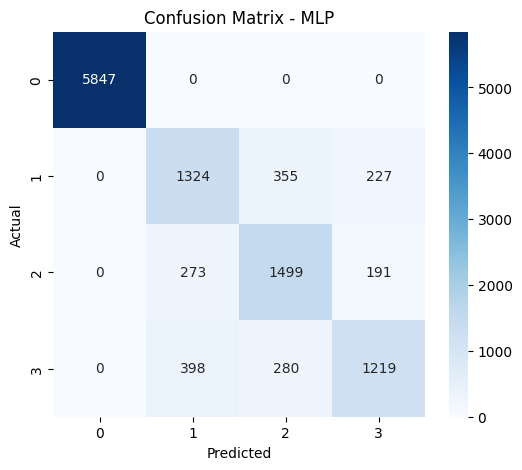

In [ ]:
mlp_results = evaluate_model(best_mlp_model, X_test_scaled, y_test, model_name="MLP")

Stacking Ensemble

In [ ]:
class KerasMLPWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, epochs=10, batch_size=32):
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.classes_ = None  # Initialize classes_ attribute

    def fit(self, X, y):
        """Train the MLP model and store class labels."""
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        self.classes_ = np.unique(y)  # Store class labels
        return self

    def predict(self, X):
        """Return predicted class labels."""
        return np.argmax(self.model.predict(X), axis=1)

    def predict_proba(self, X):
        """Return probability estimates for each class."""
        return self.model.predict(X)  # Softmax output


mlp_wrapper = KerasMLPWrapper(model=best_mlp_model)

stacking_ensemble = StackingClassifier(
    estimators=[
        ("xgb", best_xgb_model),
        ("lgbm", best_lgbm_model),
        ("rf", best_rf_model),
        ("mlp", mlp_wrapper)
    ],
    final_estimator=LogisticRegression(),
    stack_method="predict_proba"
)

stacking_ensemble.fit(X_train_resampled, y_train_resampled)


/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11369
[LightGBM] [Info] Number of data points in the train set: 93536, number of used features: 51
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:13:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:14:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:14:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:14:56] WARNING: /Users/runner/work/xgb

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11351
[LightGBM] [Info] Number of data points in the train set: 74828, number of used features: 51
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11147
[LightGBM] [Info] Number of data points in the train set: 74829, number of used features: 51
[LightGBM] [Info] Start training from score -1.386308
[LightGBM] [Info] Start training from score -1.386308
[LightGBM] [Info] Start training from score -1.386254
[LightGBM] [Info] Start training from score -1.386308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11089
[LightGBM] [Info] Number of data points in the train set: 74829, number of used features: 51
[LightGBM] [Info] Start training from score -1.386308
[LightGBM] [Info] Start training from score -1.386308
[LightGBM] [Info] Start training from score -1.386308
[LightGBM] [Info] Start training from score -1.386254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11072
[LightGBM] [Info] Number of data points in the train set: 74829, number of used features: 51
[LightGBM] [Info] Start training from score -1.386308
[LightGBM] [Info] Start training from score -1.386254
[LightGBM] [Info] Start training from score -1.386308
[LightGBM] [Info] Start training from score -1.386308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11082
[LightGBM] [Info] Number of data points in the train set: 74829, number of used features: 51
[LightGBM] [Info] Start training from score -1.386254
[LightGBM] [Info] Start training from score -1.386308
[LightGBM] [Info] Start training from score -1.386308
[LightGBM] [Info] Start training from score -1.386308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8537742123999098,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None,
                                              gamma=0.03177765487850257,
                                              grow_policy=None,
                                              importance_type=None,
                                              int...
                                               num_leaves=119, random_state=42,
                                               reg_alpha=0.09012308375319378,
                                               reg_lambda=0.0005074971554500256,
                                               subsample=0.9959664007194149)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=25,
                                                       n_estimators=225,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('mlp',
                                KerasMLPWrapper(model=<Sequential name=sequential_2, built=True>))],
                   final_estimator=LogisticRegression(),
                   stack_method='predict_proba')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11369
[LightGBM] [Info] Number of data points in the train set: 93536, number of used features: 51
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:13:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[19:14:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:14:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:14:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:14:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:14:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



===== Stacking Ensemble Evaluation =====
Accuracy: 0.8790
Precision (Weighted): 0.8788
Recall (Weighted): 0.8790
F1-score (Weighted): 0.8789


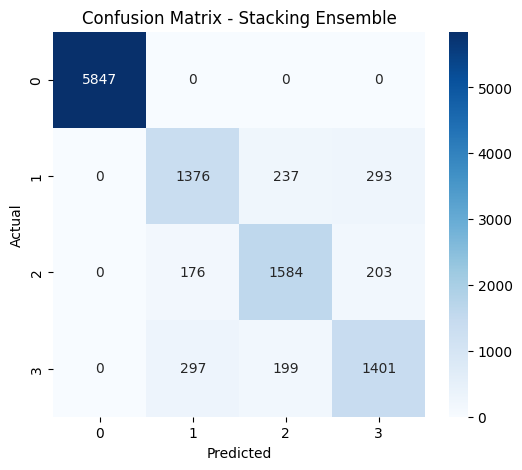

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Define base models
base_models = [
    ("xgb", best_xgb_model),
    ("lgbm", best_lgbm_model),
]

# Meta-classifier (final layer)
meta_model = LogisticRegression(solver="lbfgs", max_iter=1000, class_weight="balanced", random_state=42)

# Create stacking ensemble
stacking_ensemble = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    stack_method="auto",  # Uses 'predict_proba' where available
    n_jobs=-1
)

# Train stacking model
stacking_ensemble.fit(X_train_resampled, y_train_resampled)

# Evaluate stacking model
stacking_results = evaluate_model(stacking_ensemble, X_test_scaled, y_test, model_name="Stacking Ensemble")

Evaluation metrics

In [ ]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluates a given model on test data and prints accuracy, precision, recall, and F1-score.
    Also plots the confusion matrix.

    Parameters:
        model: The trained model to evaluate.
        X_test: Test feature set.
        y_test: True labels for test data.
        model_name (str): Name of the model (for labeling plots).
    
    Returns:
        dict: A dictionary containing all evaluation metrics.
    """
    # ✅ Fix: Check if model returns probabilities and convert to class labels
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
        y_pred = np.argmax(y_prob, axis=1)  # Convert probabilities to class labels
    elif isinstance(model, tf.keras.Model):  # If model is an MLP (TensorFlow/Keras)
        y_prob = model.predict(X_test)
        y_pred = np.argmax(y_prob, axis=1)  # Convert softmax output to class labels
    else:
        y_pred = model.predict(X_test)  # Direct class prediction (for models like RF & LGBM)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    # Print results
    print(f"\n===== {model_name} Evaluation =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-score (Weighted): {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
    }


Load All Models

In [ ]:
import joblib
from tensorflow.keras.models import load_model

#Load saved models
best_xgb_model = joblib.load("best_xgb_model.pkl")
best_rf_model = joblib.load("best_rf_model.pkl")
best_lgbm_model = joblib.load("best_lgbm_model.pkl")
best_mlp_model = load_model("mlp_checkpoint.keras", safe_mode=False)


===== XGBoost Evaluation =====
Accuracy: 0.8776
Precision (Weighted): 0.8774
Recall (Weighted): 0.8776
F1-score (Weighted): 0.8775


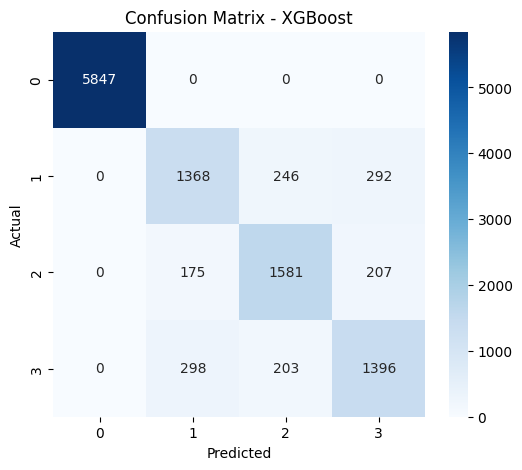


===== Random Forest Evaluation =====
Accuracy: 0.8705
Precision (Weighted): 0.8704
Recall (Weighted): 0.8705
F1-score (Weighted): 0.8704


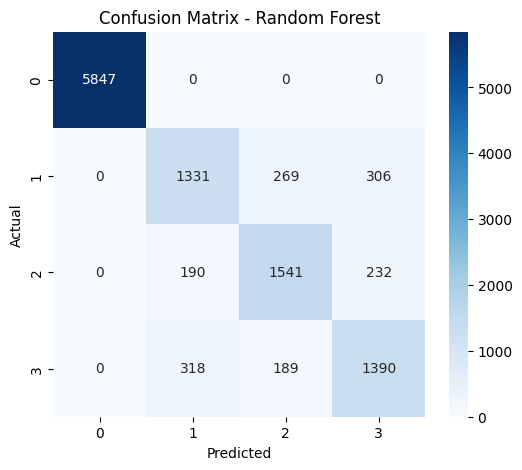

/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



===== Stacking Ensemble Evaluation =====
Accuracy: 0.8797
Precision (Weighted): 0.8794
Recall (Weighted): 0.8797
F1-score (Weighted): 0.8795


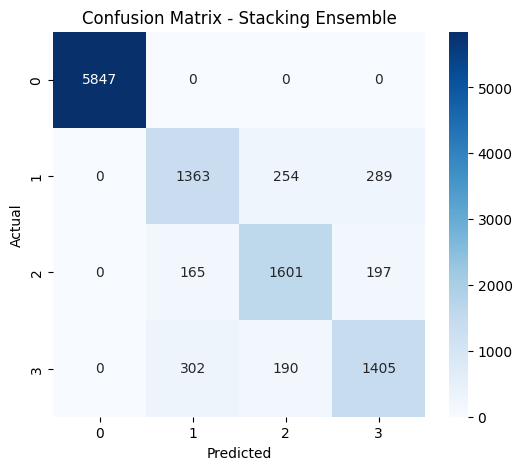

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

===== MLP Evaluation =====
Accuracy: 0.8509
Precision (Weighted): 0.8521
Recall (Weighted): 0.8509
F1-score (Weighted): 0.8506


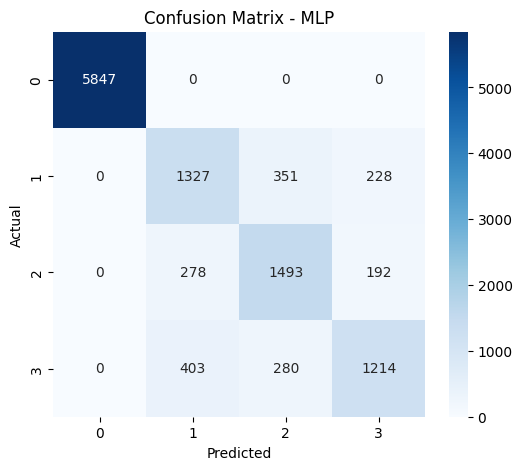

/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



===== LightGBM Evaluation =====
Accuracy: 0.8790
Precision (Weighted): 0.8788
Recall (Weighted): 0.8790
F1-score (Weighted): 0.8789


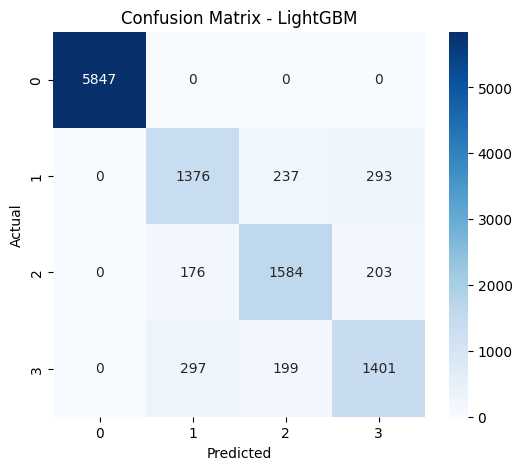

In [ ]:
xgb_results = evaluate_model(best_xgb_model, X_test_scaled, y_test, model_name="XGBoost")
rf_results = evaluate_model(best_rf_model, X_test_scaled, y_test, model_name="Random Forest")
lgbm_results = evaluate_model(best_lgbm_model, X_test_scaled, y_test, model_name="Stacking Ensemble")
mlp_results = evaluate_model(best_mlp_model, X_test_scaled, y_test, model_name="MLP")
stacking_results = evaluate_model(stacking_ensemble, X_test_scaled, y_test, model_name="LightGBM")

Feature Importance

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
363/363 ━━━━━━━━

/var/folders/g3/b62gb6fx307526l7s35ss6zh0000gn/T/ipykernel_20601/1657937074.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.array(feature_names)[top_10_idx],
/var/folders/g3/b62gb6fx307526l7s35ss6zh0000gn/T/ipykernel_20601/1657937074.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/g3/b62gb6fx307526l7s35ss6zh0000gn/T/ipykernel_20601/1657937074.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.array(feature_names)[top_10_idx],
/var/folders/g3/b62gb6fx307526l7s35ss6zh0000gn/T/ipykernel_20601/1657937074.py:14: 

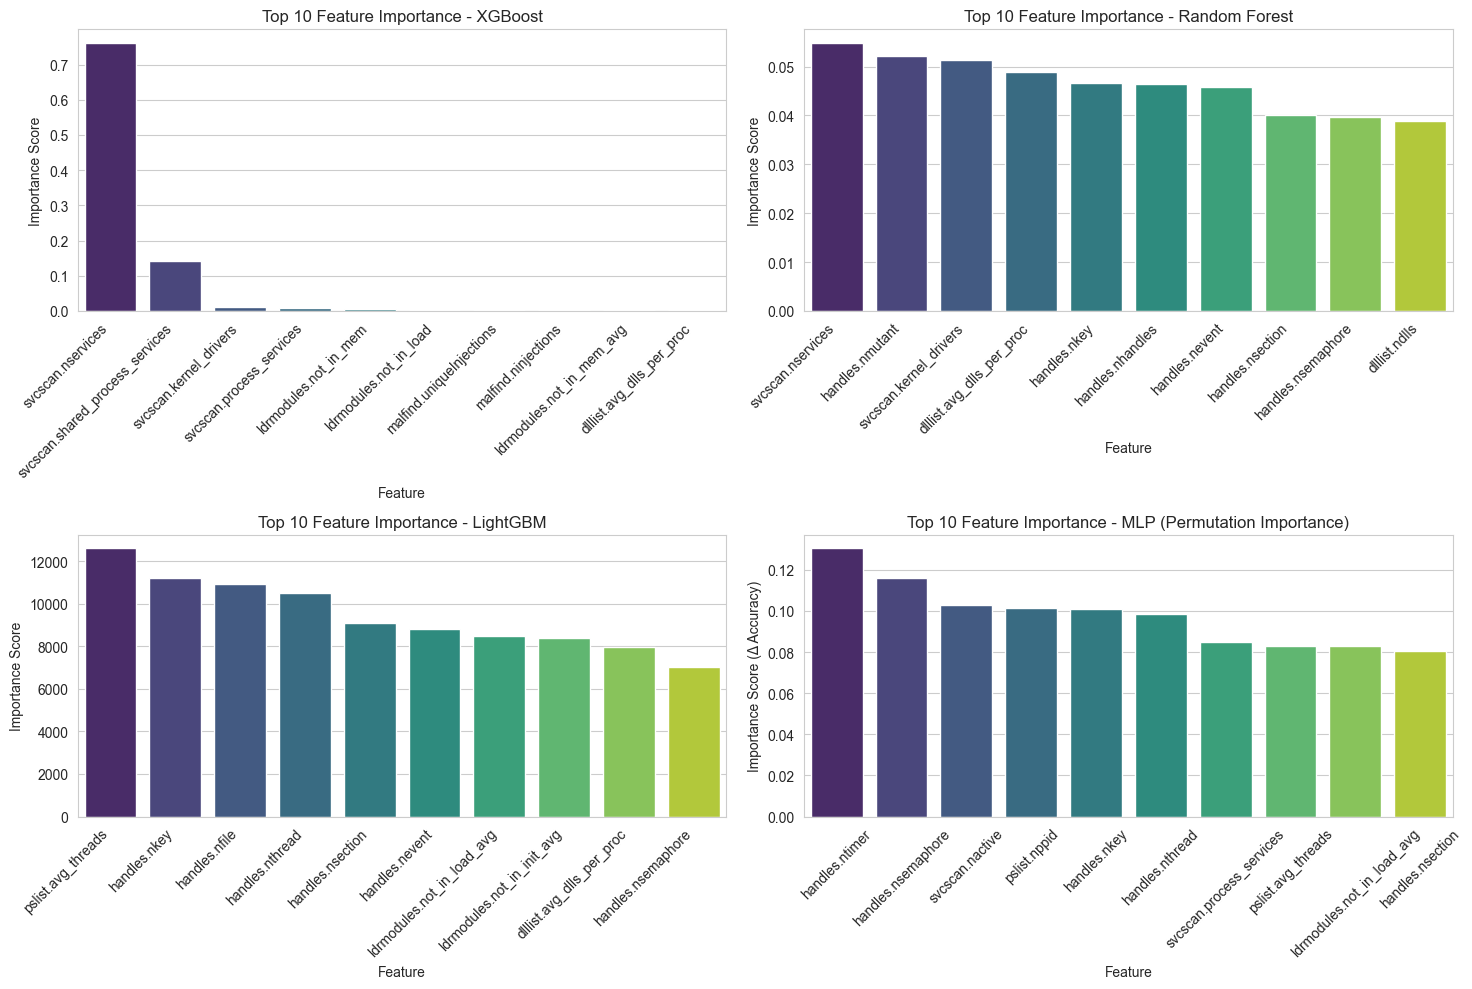

In [86]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Function to plot top 10 feature importance
def plot_top_features(importances, feature_names, title, ax):
    sorted_idx = np.argsort(importances)[::-1]  # Sort features by importance (descending)
    top_10_idx = sorted_idx[:10]  # Get top 10 feature indices

    sns.barplot(x=np.array(feature_names)[top_10_idx], 
                y=np.array(importances)[top_10_idx], 
                palette="viridis", ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xlabel("Feature")
    ax.set_ylabel("Importance Score")
    ax.set_title(title)

def mlp_permutation_importance(model, X_test, y_test, feature_names, n_repeats=10):
    """
    Custom function to compute feature importance for MLP using permutation importance.
    """
    baseline_acc = accuracy_score(y_test, np.argmax(model.predict(X_test), axis=1))  # Baseline accuracy
    feature_importances = np.zeros(X_test.shape[1])

    for i in range(X_test.shape[1]):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, i])  # Shuffle one feature

        acc = accuracy_score(y_test, np.argmax(model.predict(X_test_permuted), axis=1))
        feature_importances[i] = baseline_acc - acc  # Importance = drop in accuracy

    return feature_importances

# Compute MLP feature importance
mlp_importance = mlp_permutation_importance(best_mlp_model, X_test_scaled, y_test, X_filtered.columns)

# Get top 10 features for MLP
sorted_idx = np.argsort(mlp_importance)[::-1][:10]
top_features = np.array(X_filtered.columns)[sorted_idx]
top_importances = mlp_importance[sorted_idx]

# Create a 2x2 grid for subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot Top 10 Features for XGBoost
plot_top_features(best_xgb_model.feature_importances_, X_filtered.columns, "Top 10 Feature Importance - XGBoost", axs[0, 0])

# Plot Top 10 Features for Random Forest
plot_top_features(best_rf_model.feature_importances_, X_filtered.columns, "Top 10 Feature Importance - Random Forest", axs[0, 1])

# Plot Top 10 Features for LightGBM
plot_top_features(best_lgbm_model.feature_importances_, X_filtered.columns, "Top 10 Feature Importance - LightGBM", axs[1, 0])

# Plot MLP Feature Importance
sns.barplot(x=top_features, y=top_importances, palette="viridis", ax=axs[1, 1])
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45)
axs[1, 1].set_xlabel("Feature")
axs[1, 1].set_ylabel("Importance Score (Δ Accuracy)")
axs[1, 1].set_title("Top 10 Feature Importance - MLP (Permutation Importance)")

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


Model Comparison


===== XGBoost Evaluation =====
Accuracy: 0.8776
Precision (Weighted): 0.8774
Recall (Weighted): 0.8776
F1-score (Weighted): 0.8775

===== Random Forest Evaluation =====
Accuracy: 0.8705
Precision (Weighted): 0.8704
Recall (Weighted): 0.8705
F1-score (Weighted): 0.8704


/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



===== LightGBM Evaluation =====
Accuracy: 0.8797
Precision (Weighted): 0.8794
Recall (Weighted): 0.8797
F1-score (Weighted): 0.8795
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

===== MLP Evaluation =====
Accuracy: 0.8509
Precision (Weighted): 0.8521
Recall (Weighted): 0.8509
F1-score (Weighted): 0.8506


/Users/gavinluo/Desktop/coding/OSEF-2025/OSEF-2025-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



===== Stacking Ensemble Evaluation =====
Accuracy: 0.8790
Precision (Weighted): 0.8788
Recall (Weighted): 0.8790
F1-score (Weighted): 0.8789


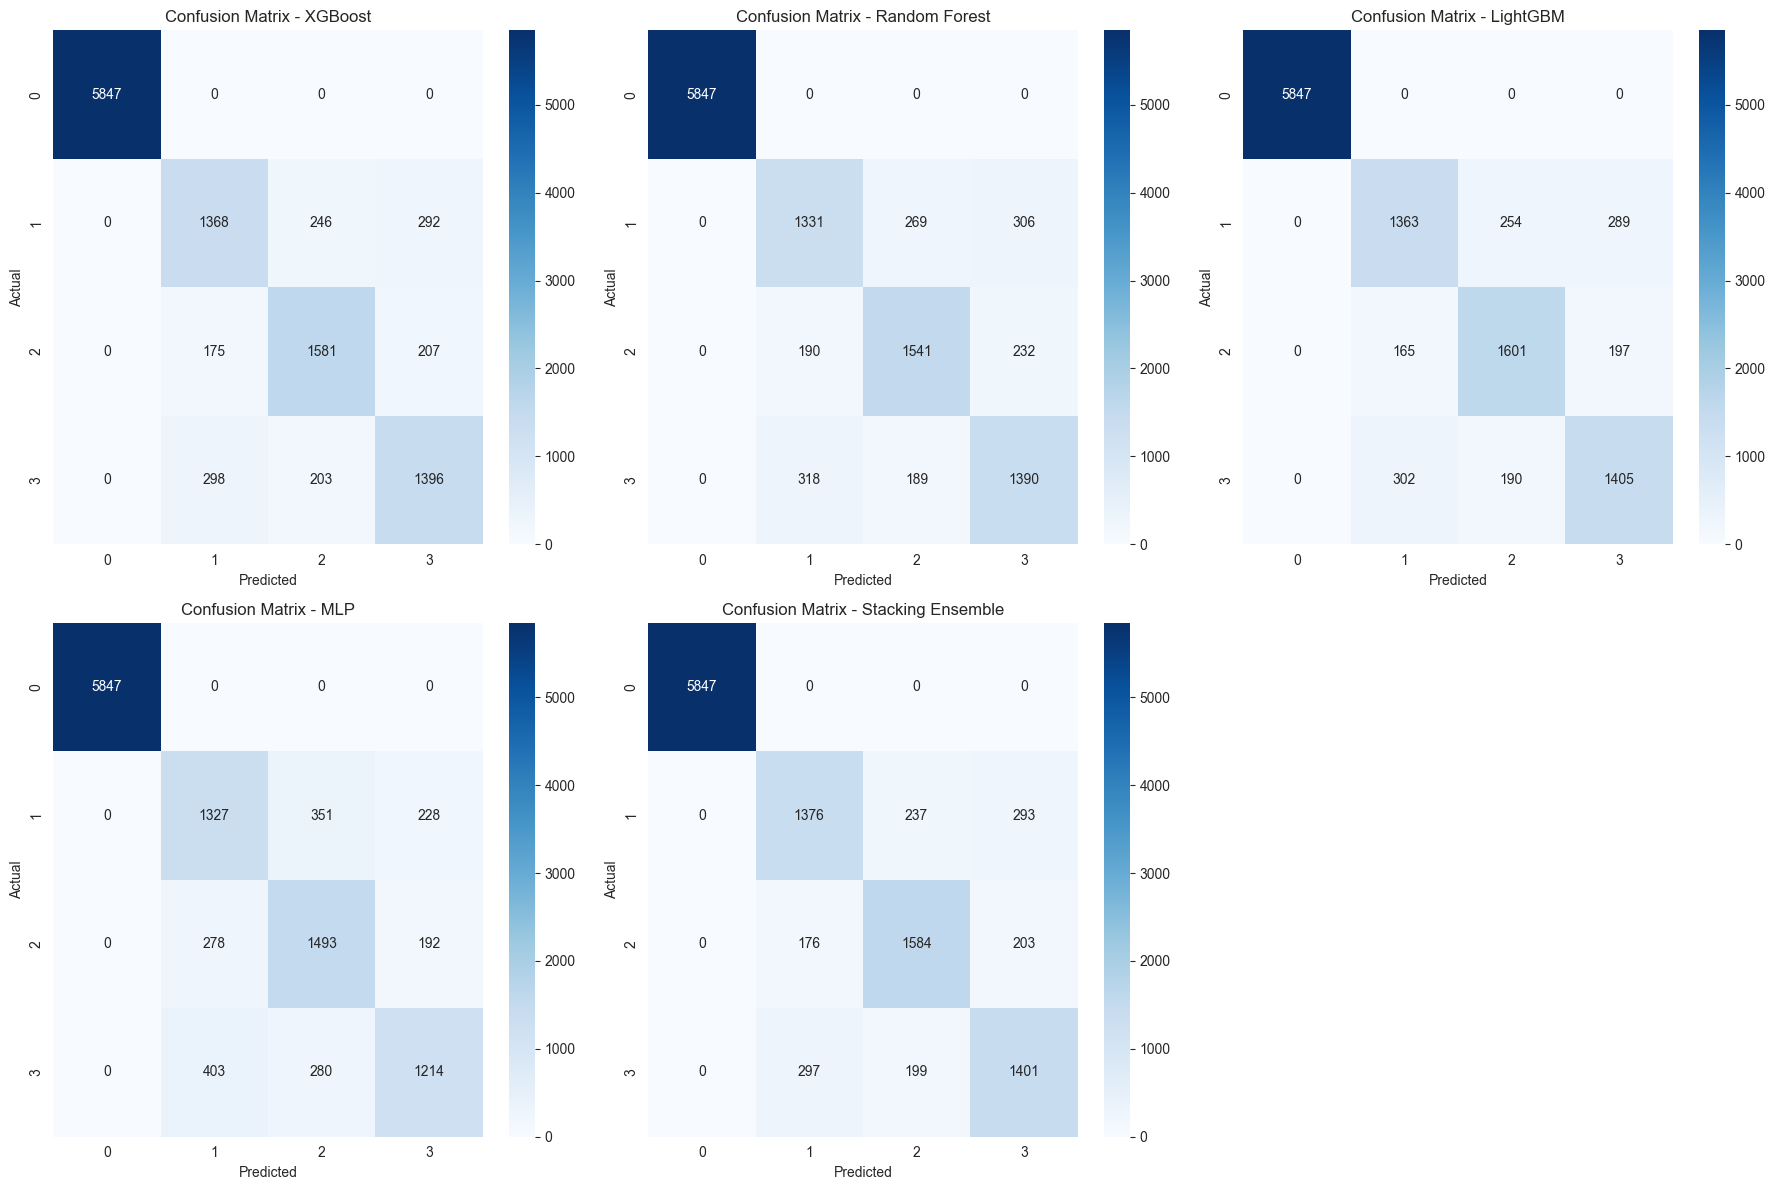

In [87]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluates a given model on test data and prints accuracy, precision, recall, and F1-score.
    Also returns the confusion matrix.

    Parameters:
        model: The trained model to evaluate.
        X_test: Test feature set.
        y_test: True labels for test data.
        model_name (str): Name of the model (for labeling plots).
    
    Returns:
        dict: A dictionary containing all evaluation metrics.
        confusion_matrix: The confusion matrix for the model.
    """
    # ✅ Fix: Check if model returns probabilities and convert to class labels
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
        y_pred = np.argmax(y_prob, axis=1)  # Convert probabilities to class labels
    elif isinstance(model, tf.keras.Model):  # If model is an MLP (TensorFlow/Keras)
        y_prob = model.predict(X_test)
        y_pred = np.argmax(y_prob, axis=1)  # Convert softmax output to class labels
    else:
        y_pred = model.predict(X_test)  # Direct class prediction (for models like RF & LGBM)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    # Print results
    print(f"\n===== {model_name} Evaluation =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-score (Weighted): {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    return cm, {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
    }

# Evaluate all models and collect confusion matrices
xgb_cm, xgb_results = evaluate_model(best_xgb_model, X_test_scaled, y_test, model_name="XGBoost")
rf_cm, rf_results = evaluate_model(best_rf_model, X_test_scaled, y_test, model_name="Random Forest")
lgbm_cm, lgbm_results = evaluate_model(best_lgbm_model, X_test_scaled, y_test, model_name="LightGBM")
mlp_cm, mlp_results = evaluate_model(best_mlp_model, X_test_scaled, y_test, model_name="MLP")
stacking_cm, stacking_results = evaluate_model(stacking_ensemble, X_test_scaled, y_test, model_name="Stacking Ensemble")

# Create a 2x3 grid for the confusion matrices
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Plot each confusion matrix in the grid
sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Blues", ax=axs[0, 0])
axs[0, 0].set_xlabel("Predicted")
axs[0, 0].set_ylabel("Actual")
axs[0, 0].set_title("Confusion Matrix - XGBoost")

sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", ax=axs[0, 1])
axs[0, 1].set_xlabel("Predicted")
axs[0, 1].set_ylabel("Actual")
axs[0, 1].set_title("Confusion Matrix - Random Forest")

sns.heatmap(lgbm_cm, annot=True, fmt="d", cmap="Blues", ax=axs[0, 2])
axs[0, 2].set_xlabel("Predicted")
axs[0, 2].set_ylabel("Actual")
axs[0, 2].set_title("Confusion Matrix - LightGBM")

sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Blues", ax=axs[1, 0])
axs[1, 0].set_xlabel("Predicted")
axs[1, 0].set_ylabel("Actual")
axs[1, 0].set_title("Confusion Matrix - MLP")

sns.heatmap(stacking_cm, annot=True, fmt="d", cmap="Blues", ax=axs[1, 1])
axs[1, 1].set_xlabel("Predicted")
axs[1, 1].set_ylabel("Actual")
axs[1, 1].set_title("Confusion Matrix - Stacking Ensemble")

# Hide the empty subplot
axs[1, 2].axis("off")

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Store evaluation results
model_results = {
    "Model": ["XGBoost", "Random Forest", "LightGBM", "MLP", "Stacking Ensemble"],
    "Accuracy": [0.8776, 0.8705, 0.8790, 0.8509, 0.8797],
    "Precision": [0.8774, 0.8704, 0.8788, 0.8521, 0.8794],
    "Recall": [0.8776, 0.8705, 0.8790, 0.8509, 0.8797],
    "F1-score": [0.8775, 0.8704, 0.8789, 0.8506, 0.8795],
}

# Convert to Pandas DataFrame
df_results = pd.DataFrame(model_results)

# Convert DataFrame to long format for plotting
df_long = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")


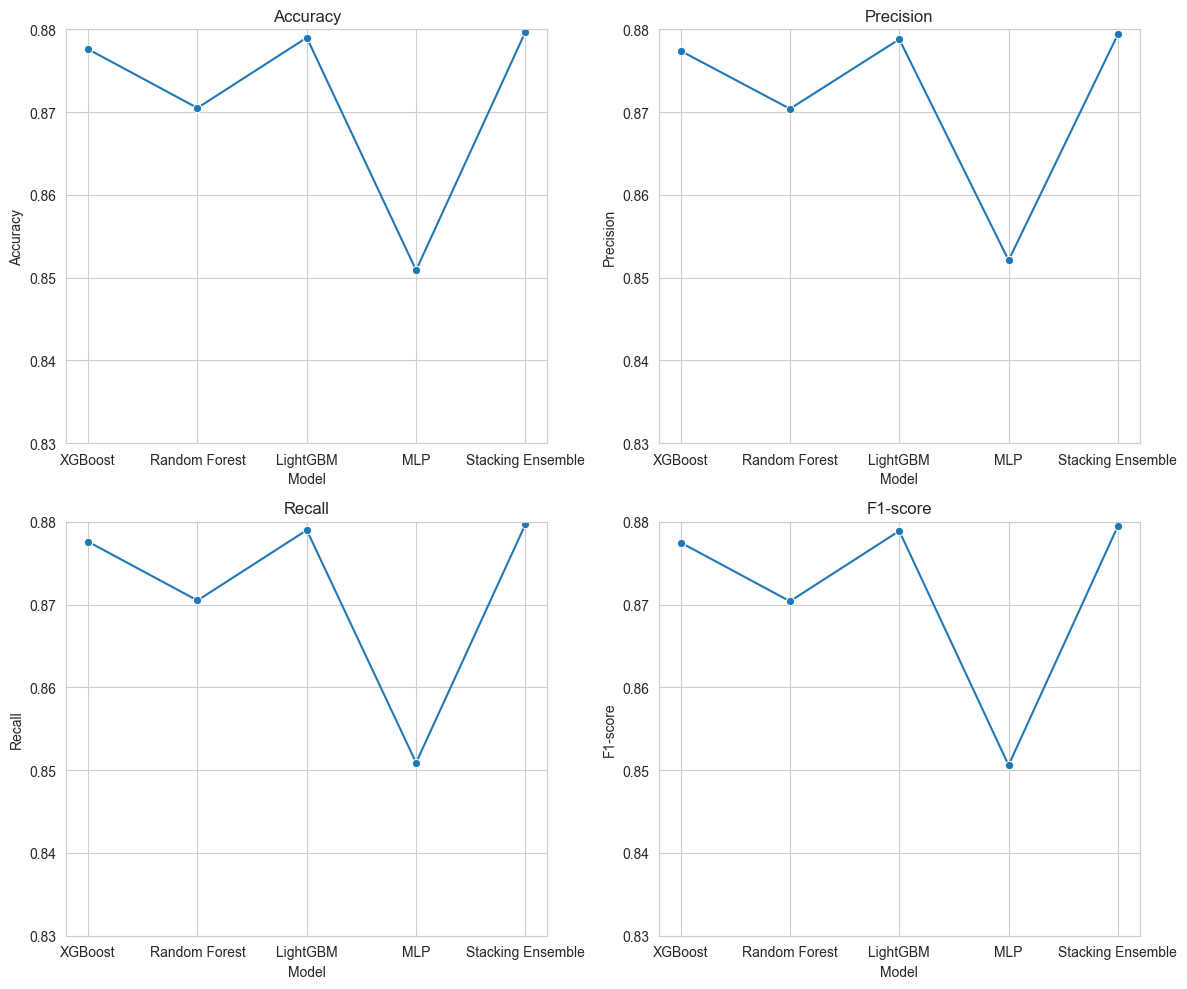

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Store evaluation results
model_results = {
    "Model": ["XGBoost", "Random Forest", "LightGBM", "MLP", "Stacking Ensemble"],
    "Accuracy": [0.8776, 0.8705, 0.8790, 0.8509, 0.8797],
    "Precision": [0.8774, 0.8704, 0.8788, 0.8521, 0.8794],
    "Recall": [0.8776, 0.8705, 0.8790, 0.8509, 0.8797],
    "F1-score": [0.8775, 0.8704, 0.8789, 0.8506, 0.8795],
}

# Convert to Pandas DataFrame
df_results = pd.DataFrame(model_results)

# Create four subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Accuracy
sns.lineplot(data=df_results, x="Model", y="Accuracy", marker='o', ax=axes[0, 0])
axes[0, 0].set_title("Accuracy")
axes[0, 0].set_ylim(0.83, 0.88)  # Adjust y-axis for better clarity

# Plot Precision
sns.lineplot(data=df_results, x="Model", y="Precision", marker='o', ax=axes[0, 1])
axes[0, 1].set_title("Precision")
axes[0, 1].set_ylim(0.83, 0.88)  # Adjust y-axis for better clarity

# Plot Recall
sns.lineplot(data=df_results, x="Model", y="Recall", marker='o', ax=axes[1, 0])
axes[1, 0].set_title("Recall")
axes[1, 0].set_ylim(0.83, 0.88)  # Adjust y-axis for better clarity

# Plot F1-score
sns.lineplot(data=df_results, x="Model", y="F1-score", marker='o', ax=axes[1, 1])
axes[1, 1].set_title("F1-score")
axes[1, 1].set_ylim(0.83, 0.88)  # Adjust y-axis for better clarity

# Adjust layout
plt.tight_layout()
plt.show()


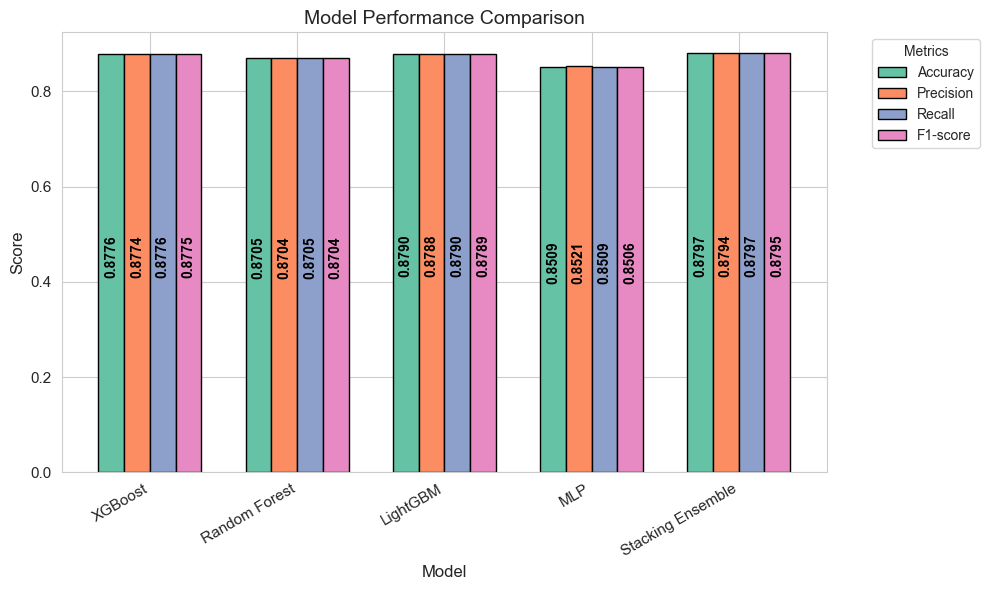

In [78]:
# Set style
sns.set_style("whitegrid")

# Set figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Reduce width for a more compact look

# Define a clear color palette
colors = sns.color_palette("Set2", n_colors=len(df_results))

# Create bar plot
df_results.set_index("Model").plot(kind="bar", color=colors, ax=ax, width=0.7, edgecolor="black")

# Add exact values inside the bars, rotated vertically
for bars in ax.containers:
    ax.bar_label(bars, fmt="%.4f", label_type="center", fontsize=10, color="black", weight="bold", rotation=90, padding=5)

# Formatting
plt.title("Model Performance Comparison", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=30, ha="right", fontsize=11)
plt.yticks(fontsize=11)

# Move legend outside the plot
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()

# Show plot
plt.show()


Feature Correlation

In [ ]:
import numpy as np

# Compute correlation matrix
correlation_matrix = X_filtered.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5, center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [13]:
from graphviz import Digraph

# Create the Graph object
dot = Digraph(comment="Machine Learning Workflow")

# Set Graph Attributes (Left to Right + Top to Bottom, Font, Spacing)
dot.attr(rankdir="TB", nodesep="0.6", ranksep="0.8", fontname="Helvetica", fontsize="12")

# Define Nodes with Color Coding
dot.node("A", "Data Collection", shape="folder", style="filled", fillcolor="lightblue")
dot.node("B", "Data Preprocessing", shape="box", style="filled", fillcolor="lightblue")
dot.node("C", "Feature Selection & Scaling", shape="parallelogram", style="filled", fillcolor="lightblue")
dot.node("D", "Train-Test Split", shape="parallelogram", style="filled", fillcolor="lightblue")

# Hyperparameter Tuning
dot.node("E1", "XGBoost Tuning", shape="hexagon", style="filled", fillcolor="lightgoldenrodyellow")
dot.node("E2", "LightGBM Tuning", shape="hexagon", style="filled", fillcolor="lightgoldenrodyellow")
dot.node("E3", "Random Forest Tuning", shape="hexagon", style="filled", fillcolor="lightgoldenrodyellow")

# Model Training
dot.node("F1", "Train XGBoost", shape="ellipse", style="filled", fillcolor="lightgreen")
dot.node("F2", "Train LightGBM", shape="ellipse", style="filled", fillcolor="lightgreen")
dot.node("F3", "Train Random Forest", shape="ellipse", style="filled", fillcolor="lightgreen")
dot.node("F4", "Train MLP Model", shape="ellipse", style="filled", fillcolor="lightseagreen")

# Stacking Ensemble
dot.node("G", "Stacking Ensemble", shape="diamond", style="filled", fillcolor="lightcoral")

# Final Model
dot.node("H", "Final Model", shape="box", style="filled", fillcolor="gold")

# Model Evaluation
dot.node("I", "Model Evaluation", shape="note", style="filled", fillcolor="lightcoral")
dot.node("J", "Metrics: Accuracy, Precision, Recall, F1", shape="note", style="filled", fillcolor="lightcoral")

# Save Best Model
dot.node("K", "Save Best Models", shape="cylinder", style="filled", fillcolor="lightgray")

# Define Edges (Connections)
dot.edge("A", "B")
dot.edge("B", "C")
dot.edge("C", "D")
dot.edge("D", "F1")  
dot.edge("D", "F2")  
dot.edge("D", "F3")  
dot.edge("D", "F4")  

dot.edge("E1", "F1")  # Hyperparameter tuning → Training
dot.edge("E2", "F2")
dot.edge("E3", "F3")

dot.edge("F1", "G")  # Model Training → Stacking
dot.edge("F2", "G")
dot.edge("F3", "G")
dot.edge("F4", "G")  # MLP also goes into Stacking

dot.edge("G", "H")  # Stacking → Final Model
dot.edge("H", "I")  # Final Model → Evaluation
dot.edge("I", "J")  # Evaluation → Metrics
dot.edge("J", "K")  # Metrics → Save Best Models

# Render and Display the Graph
dot.render("ml_workflow", format="png", cleanup=True)  # Saves as 'ml_workflow.png'
dot.view()


'ml_workflow.pdf'

In [15]:
from graphviz import Digraph

# Create the Graph object
dot = Digraph(comment="Malware Impact vs. Classification")

# Set Graph Attributes (Direction, Font, Spacing)
dot.attr(rankdir="TB", nodesep="0.6", ranksep="0.8", fontname="Helvetica", fontsize="12")

# Malware Impact Path (Red)
dot.node("A", "Malware Enters System", shape="folder", style="filled", fillcolor="lightcoral")
dot.node("B", "Compromises Files & Data", shape="parallelogram", style="filled", fillcolor="lightcoral")
dot.node("C", "Spreads & Escalates", shape="parallelogram", style="filled", fillcolor="lightcoral")
dot.node("D", "Causes Damage: Data Theft, Corruption, Ransomware", shape="box", style="filled", fillcolor="red")

# Classification Path (Blue)
dot.node("E", "Malware Classification", shape="hexagon", style="filled", fillcolor="lightblue")
dot.node("F", "Identifies Malware Type", shape="ellipse", style="filled", fillcolor="lightblue")
dot.node("G", "Enables Security Measures", shape="ellipse", style="filled", fillcolor="lightblue")
dot.node("H", "Prevents & Mitigates Damage", shape="box", style="filled", fillcolor="green")

# Define Edges (Connections)
dot.edge("A", "B")  # Malware spreading
dot.edge("B", "C")
dot.edge("C", "D")  

dot.edge("A", "E", label="Classification Starts")  # Classification entry point
dot.edge("E", "F")
dot.edge("F", "G")
dot.edge("G", "H")  # Prevention & mitigation

# Render and Display the Graph
dot.render("malware_classification_flowchart", format="png", cleanup=True)
dot.view()


'malware_classification_flowchart.pdf'

In [3]:
from graphviz import Digraph

# Create the Graph object
dot = Digraph(comment="Stacking Ensemble Architecture")

# Set Graph Attributes (Left to Right for better visualization)
dot.attr(rankdir="TB", nodesep="0.6", ranksep="0.8", fontname="Helvetica", fontsize="12")

# Input Layer (Feature Set)
dot.node("A", "Input Data (Features)", shape="folder", style="filled", fillcolor="lightblue")

# Base Models
dot.node("B1", "XGBoost", shape="ellipse", style="filled", fillcolor="lightgreen")
dot.node("B2", "LightGBM", shape="ellipse", style="filled", fillcolor="lightgreen")
dot.node("B3", "Random Forest", shape="ellipse", style="filled", fillcolor="lightgreen")
dot.node("B4", "MLP (Neural Network)", shape="ellipse", style="filled", fillcolor="lightseagreen")

# Meta-Classifier
dot.node("C", "Meta-Classifier (Logistic Regression)", shape="diamond", style="filled", fillcolor="gold")

# Final Prediction
dot.node("D", "Final Prediction", shape="box", style="filled", fillcolor="lightgray")

# Define Edges (Connections)
dot.edge("A", "B1")
dot.edge("A", "B2")
dot.edge("A", "B3")
dot.edge("A", "B4")

dot.edge("B1", "C")
dot.edge("B2", "C")
dot.edge("B3", "C")
dot.edge("B4", "C")

dot.edge("C", "D")

# Render and Display the Graph
dot.render("stacking_ensemble_diagram", format="png", cleanup=True)
dot.view()


'stacking_ensemble_diagram.pdf'

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Collect evaluation results
model_results = {
    "Model": ["XGBoost", "Random Forest", "LightGBM", "MLP", "Stacking Ensemble"],
    "Accuracy": [xgb_results["Accuracy"], rf_results["Accuracy"], lgbm_results["Accuracy"], mlp_results["Accuracy"], stacking_results["Accuracy"]],
    "F1-score": [xgb_results["F1-score"], rf_results["F1-score"], lgbm_results["F1-score"], mlp_results["F1-score"], stacking_results["F1-score"]],
    "Precision": [xgb_results["Precision"], rf_results["Precision"], lgbm_results["Precision"], mlp_results["Precision"], stacking_results["Precision"]],
    "Recall": [xgb_results["Recall"], rf_results["Recall"], lgbm_results["Recall"], mlp_results["Recall"], stacking_results["Recall"]],
}

# Convert dictionary to DataFrame
df_results = pd.DataFrame(model_results)

# Convert DataFrame to long format for Seaborn boxplot
df_long = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Create box plots
plt.figure(figsize=(12, 6))
sns.boxplot(x="Metric", y="Score", data=df_long, hue="Model", palette="coolwarm")

# Formatting
plt.title("Box Plots of Model Performance Metrics")
plt.xlabel("Evaluation Metric")
plt.ylabel("Score")
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show plot
plt.show()


NameError: name 'xgb_results' is not defined